In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


from sklearn import preprocessing

pd.options.mode.copy_on_write = True
pd.options.mode.chained_assignment = None  # default='warn'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Useful Package 

import warnings
warnings.filterwarnings("ignore")   # 忽略警告信息

from scipy.stats import norm, skew  # 获取统计信息
from scipy import stats
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))  # 限制浮点输出到小数点后3位
import os
print('\n'.join(os.listdir('/kaggle/input/house-prices-advanced-regression-techniques')))  # 列出目录中可用的文件

sample_submission.csv
data_description.txt
train.csv
test.csv


In [3]:
train = pd.read_csv(
    '/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
# missing value in tran
missing_train = train.isnull().sum()
print("Training Data Missing Values:\n", missing_train[missing_train > 0])

test = pd.read_csv(
    '/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
# missing value in test
test_ID = test['Id']
train_ID = train['Id']


train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)



missing_test = test.isnull().sum()
print("\nTest Data Missing Values:\n", missing_test[missing_test > 0])

Training Data Missing Values:
 LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Test Data Missing Values:
 MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType       894
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
Gara

## ***目标变量分析***

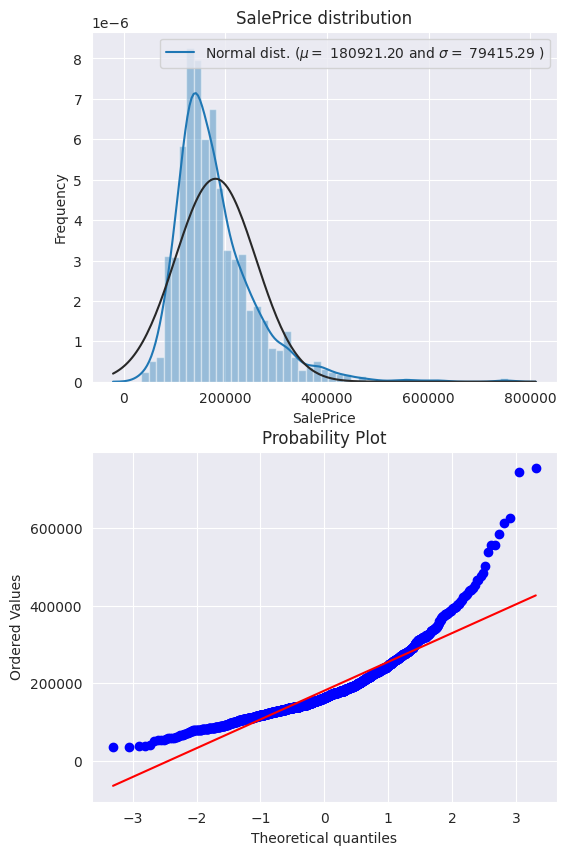

In [4]:
fig, ax = plt.subplots(nrows=2, figsize=(6, 10))
sns.distplot(train['SalePrice'], fit=norm, ax=ax[0])
(mu, sigma) = norm.fit(train['SalePrice'])
ax[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
ax[0].set_ylabel('Frequency')
ax[0].set_title('SalePrice distribution')
# QQ图
stats.probplot(train['SalePrice'], plot=ax[1])
plt.show()

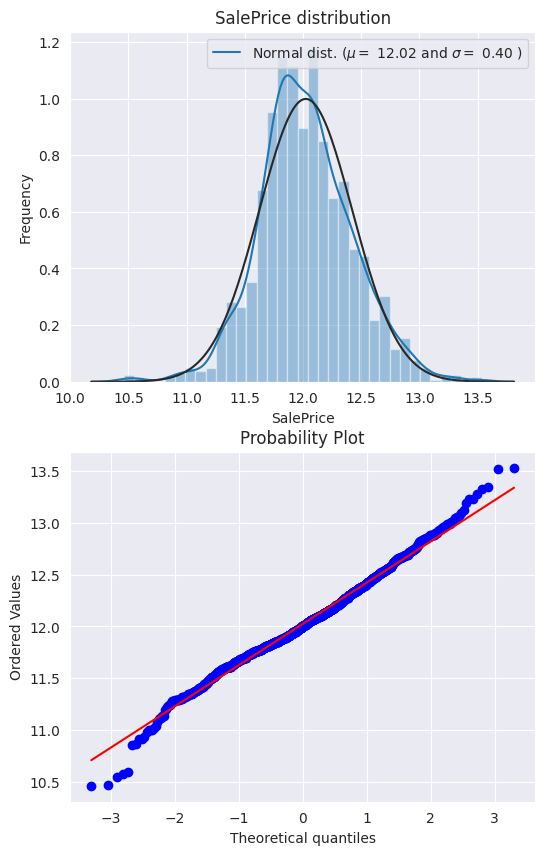

In [5]:
# 使用numpy中函数log1p()将log(1+x)应用于列的所有元素
train["SalePrice"] = np.log1p(train["SalePrice"])

# 查看转换后数据分布
# 分布图
fig, ax = plt.subplots(nrows=2, figsize=(6, 10))
sns.distplot(train['SalePrice'], fit=norm, ax=ax[0])
(mu, sigma) = norm.fit(train['SalePrice'])
ax[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(
    mu, sigma)], loc='best')
ax[0].set_ylabel('Frequency')
ax[0].set_title('SalePrice distribution')

# QQ图
stats.probplot(train['SalePrice'], plot=ax[1])
plt.show()

## ***合并训练集和测试集的数据***

In [6]:
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [7]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.248
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317
3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849
4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.000,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.073
1456,20,RL,85.000,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.255
1457,70,RL,66.000,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493
1458,20,RL,68.000,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864


## ***数据工程***

In [8]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657
MiscFeature,96.403
Alley,93.217
Fence,80.439
MasVnrType,60.500
FireplaceQu,48.647
LotFrontage,16.650
GarageFinish,5.447
GarageQual,5.447
GarageCond,5.447


In [9]:
#Combine 处理

all_data_2 = all_data.copy()
all_data_2['Conditions'] = np.where(all_data['Condition1'] == all_data['Condition2'] ,1,2)
all_data_2['Exteriors'] = np.where(all_data['Exterior1st'] == all_data['Exterior2nd'] ,1,2)
all_data_2['TotalFlrSF'] = all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data_2['TotalBath'] = all_data['BsmtFullBath'] + all_data['BsmtHalfBath']+all_data['FullBath']+all_data['HalfBath']
all_data_2['DPArea'] = all_data['WoodDeckSF'] + all_data['OpenPorchSF']+all_data['EnclosedPorch']+all_data['3SsnPorch']+all_data['ScreenPorch']

## ***缺失值处理***

In [10]:
#Missing 处理
#分类变量

all_data["PoolQC"] = all_data["PoolQC"].fillna('None')
all_data["MiscFeature"] = all_data["MiscFeature"].fillna('None')
all_data["Alley"] = all_data["Alley"].fillna('None')
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna('None')
all_data["Fence"] = all_data["Fence"].fillna("None")

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['Utilities'] = all_data['Utilities'].fillna("None")


#数值变量   

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.mean()))


In [11]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


## ***分类数值处理***

In [12]:

#将一些数值性但实际是分类数值的转换为str类型
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [13]:
#Combine 处理

all_data_2 = all_data.copy()
all_data_2['Conditions'] = np.where(all_data['Condition1'] == all_data['Condition2'] ,1,2)
all_data_2['Exteriors'] = np.where(all_data['Exterior1st'] == all_data['Exterior2nd'] ,1,2)
all_data_2['TotalFlrSF'] = all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data_2['TotalBath'] = all_data['BsmtFullBath'] + all_data['BsmtFullBath']+all_data['FullBath']+all_data['HalfBath']
all_data_2['DPArea'] = all_data['WoodDeckSF'] + all_data['OpenPorchSF']+all_data['OpenPorchSF']+all_data['3SsnPorch']+all_data['ScreenPorch']

all_data_2.drop(['Condition1','Condition2','Exterior1st','Exterior2nd','1stFlrSF','2ndFlrSF','BsmtFullBath','BsmtFullBath','FullBath','HalfBath','WoodDeckSF','OpenPorchSF','OpenPorchSF','3SsnPorch','ScreenPorch'],axis=1, inplace=True)

In [14]:
all_data_2.drop(['Condition1','Condition2','Exterior1st','Exterior2nd','1stFlrSF','2ndFlrSF','BsmtFullBath','BsmtFullBath','FullBath','HalfBath','WoodDeckSF','OpenPorchSF','OpenPorchSF','3SsnPorch','ScreenPorch'],axis=1, inplace=True)

In [15]:
# 量化转换

all_data_2['Street'] = np.where(all_data_2['Street'] == 'Grvl',1,0)
all_data_2['SaleCondition'] = np.where(all_data_2['SaleCondition'] == 'Normal',1,0)

all_data_2['Alley'] = all_data_2['Alley'].apply(
    lambda x: 0 if pd.isna(x) else 1)


mapping= {
    'AllPub': 4,
    'NoSewr': 3,
    'NoSeWa': 2,
    'ELO': 1,
    np.nan:0
}
all_data_2['Utilities'] = all_data_2['Utilities'].replace(mapping)




mapping= {
    'Lvl': 4,
    'Bnk': 3,
    'HLS': 2,
    'Low': 1,
    np.nan: 0
}
all_data_2['LandContour'] = all_data_2['LandContour'].replace(mapping)




mapping0= {
    'Reg': 4,
    'IR1': 3,
    'IR2': 2,
    'IR3': 1,
    np.nan: 0
}
all_data_2['LotShape'] = all_data_2['LotShape'].replace(mapping0)





mapping1= {
'Y':1,
'N':0,  
}
all_data_2['CentralAir'] = all_data_2['CentralAir'].replace(mapping1)


mapping2= {
    'Typ': 7,
    'Min1': 6,
    'Min2': 5,
    'Mod': 4,
    'Maj1': 3,
    'Maj2': 2,
    'Sev': 1,
    'Sal': 0,
    np.nan: 0
}
all_data_2['Functional'] = all_data_2['Functional'].replace(mapping2)



mapping3= {
    'Fin': 3,
    'RFn': 2,
    'Unf': 1,
    np.nan: 0
}
all_data_2['GarageFinish'] = all_data_2['GarageFinish'].replace(mapping3)

mapping4= {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    np.nan: 0
}
all_data_2['GarageQual'] = all_data_2['GarageQual'].replace(mapping4)
all_data_2['FireplaceQu'] = all_data_2['FireplaceQu'].replace(mapping4)
all_data_2['KitchenQual'] = all_data_2['KitchenQual'].replace(mapping4)
all_data_2['ExterCond'] = all_data_2['ExterCond'].replace(mapping4)
all_data_2['HeatingQC'] = all_data_2['HeatingQC'].replace(mapping4)

mapping5= {
    'Y': 2,
    'P': 1,
    'N': 0,
    np.nan: 0
}

all_data_2['PavedDrive'] = all_data_2['PavedDrive'].replace(mapping5)




all_data_2['Fence'] = all_data_2['Fence'].apply(lambda x: 0 if pd.isna(x) else 1)


all_data_2["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))

all_data_na = (all_data_2.isnull().sum() / len(all_data_2)) * 100
#pd.set_option('display.max_rows', 500)
all_data_na.sort_values()
#pd.reset_option('display.max_rows')

MSSubClass     0.000
GarageFinish   0.000
GarageYrBlt    0.000
GarageType     0.000
FireplaceQu    0.000
                ... 
MasVnrArea     0.000
MasVnrType     0.000
RoofMatl       0.000
BsmtQual       0.000
DPArea         0.000
Length: 71, dtype: float64

In [16]:
numeric_feats = all_data_2.dtypes[all_data_2.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data_2[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947
PoolArea,16.898
Street,15.500
LotArea,12.822
LowQualFinSF,12.089
KitchenAbvGr,4.302
BsmtFinSF2,4.146
EnclosedPorch,4.004
BsmtHalfBath,3.932
MasVnrArea,2.614


In [17]:
new_skewness = skewness[skewness.abs() > 0.75]
print("有{}个高偏度特征被Box-Cox变换".format(new_skewness.shape[0]))

有40个高偏度特征被Box-Cox变换


In [18]:
from scipy.special import boxcox1p

skewed_features = new_skewness.index 
lam = 0.15
epsilon = 1e-5
for feat in skewed_features:
    # 偏移数据，确保所有值都是正数
    min_val = all_data_2[feat].min()
    all_data_2[feat] =  all_data_2[feat] - min_val + epsilon
    all_data_2[feat] = boxcox1p( all_data_2[feat], lam)

In [19]:
all_data_3 = pd.get_dummies(all_data_2)
print(all_data_3.shape)

(2919, 251)


In [20]:
all_data_3.head()

,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,...,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,5.134,18.572,0.000,0.000,1.541,1.541,2.260,7.201,5.461,8.059,...,False,False,False,False,False,False,False,False,False,True
1,5.654,19.143,0.000,0.000,1.541,1.541,2.056,6.733,4.263,0.000,...,False,False,False,False,False,False,False,False,False,True
2,5.248,19.854,0.000,0.000,1.194,1.541,2.260,7.169,5.427,7.647,...,False,False,False,False,False,False,False,False,False,True
3,4.927,19.119,0.000,0.000,1.194,1.541,2.260,5.094,3.859,0.000,...,False,False,False,False,False,False,False,False,False,True
4,5.774,20.927,0.000,0.000,1.194,1.541,2.440,7.153,5.357,9.392,...,False,False,False,False,False,False,False,False,False,True


**特征性方差检验**

In [21]:
feature_variances = all_data_3.var()
feature_variances.sort_values()

Fence               0.000
Alley               0.000
MSSubClass_150      0.000
RoofMatl_Membran    0.000
MiscFeature_TenC    0.000
                    ...  
GarageYrBlt        10.315
BsmtUnfSF          11.607
DPArea             14.618
MasVnrArea         16.947
BsmtFinSF1         26.282
Length: 251, dtype: float64

#### 导入算法包

In [22]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb

In [23]:
train = all_data_3[:ntrain]
test = all_data_3[ntrain:]

In [24]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [25]:

# 岭回归

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# 弹性回归

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))


# 拉索回归
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))


GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [26]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1271 (0.0154)



In [27]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1326 (0.0196)



In [28]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1269 (0.0154)



In [29]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6

In [30]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [31]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
0.07893183583842144


In [32]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = lgb_pred
sub.to_csv('submission.csv',index=False)